# Credit Analysis

### 1. Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import lightgbm as ltb
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

### 2. Working with Files

In [2]:
application_record = application_df = pd.read_csv("application_record.csv")
credit_record = credit_df = pd.read_csv("credit_record.csv")
pd.options.display.float_format = '{:.2f}'.format
print(application_record.shape,credit_record.shape)

(438557, 18) (1048575, 3)


### 3. EDA Part 1

##### 3.1 User Record preview

In [3]:
application_record

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00
1,5008805,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00
2,5008806,M,Y,Y,0,112500.00,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.00
3,5008808,F,N,Y,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00
4,5008809,F,N,Y,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.00,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.00
438553,6840222,F,N,N,0,103500.00,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.00
438554,6841878,F,N,N,0,54000.00,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.00
438555,6842765,F,N,Y,0,72000.00,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.00


##### 3.2 Credit Record Preview

In [4]:
credit_record

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


##### 3.3 Identifying Null Variables

In [5]:
application_record.isnull().sum()/application_df.shape[0]*100

ID                     0.00
CODE_GENDER            0.00
FLAG_OWN_CAR           0.00
FLAG_OWN_REALTY        0.00
CNT_CHILDREN           0.00
AMT_INCOME_TOTAL       0.00
NAME_INCOME_TYPE       0.00
NAME_EDUCATION_TYPE    0.00
NAME_FAMILY_STATUS     0.00
NAME_HOUSING_TYPE      0.00
DAYS_BIRTH             0.00
DAYS_EMPLOYED          0.00
FLAG_MOBIL             0.00
FLAG_WORK_PHONE        0.00
FLAG_PHONE             0.00
FLAG_EMAIL             0.00
OCCUPATION_TYPE       30.60
CNT_FAM_MEMBERS        0.00
dtype: float64

In [6]:
credit_record.isnull().sum()/application_df.shape[0]*100

ID               0.00
MONTHS_BALANCE   0.00
STATUS           0.00
dtype: float64

##### 3.4 Boxplot for children count and family members count

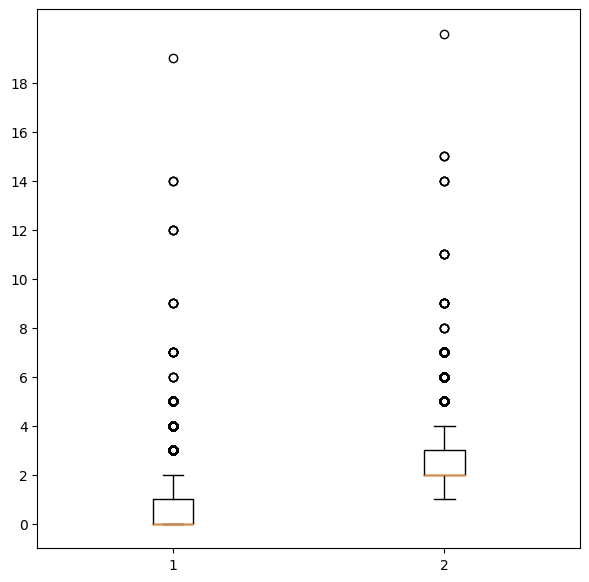

In [7]:
plt.figure(figsize=(7,7))
plt.boxplot(application_record[['CNT_CHILDREN','CNT_FAM_MEMBERS']])
plt.yticks(np.arange(0,20,2))
plt.show()

##### 3.5 CountPlot for Income vs CarOwnerShip

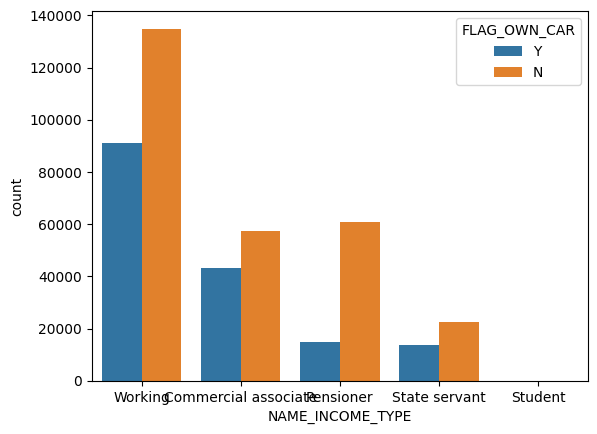

In [8]:
sns.countplot(x='NAME_INCOME_TYPE',hue='FLAG_OWN_CAR',data=application_record)
rcParams['figure.figsize'] = 20, 10

### 4. Data Transformation and Analysis

##### 4.1 Classification of Debts

In [9]:
status_dict = {'C' : 'Good_Debt',
               'X' : 'Good_Debt',
               '0' : 'Bad_Debt',
               '1' : 'Bad_Debt',
               '2' : 'Bad_Debt',
               '3' : 'Bad_Debt',
               '4' : 'Bad_Debt',
               '5' : 'Bad_Debt'}
credit_record.replace({'STATUS' : status_dict}, inplace=True)
credit_record = credit_record.value_counts(subset=['ID','STATUS']).unstack(fill_value=0)
credit_record

STATUS,Bad_Debt,Good_Debt
ID,,
5001711,3,1
5001712,10,9
5001713,0,22
5001714,0,15
5001715,0,60
...,...,...
5150482,12,6
5150483,0,18
5150484,12,1


##### 4.2 Approval Status based on debt classification

In [10]:
credit_record.loc[(credit_record['Good_Debt'] > credit_record['Bad_Debt']), 'CREDIT_APPROVAL_STATUS'] = 1
credit_record.loc[(credit_record['Good_Debt'] <= credit_record['Bad_Debt']), 'CREDIT_APPROVAL_STATUS'] = 0

credit_record['MONTHS_IN_BOOKS'] = credit_record['Good_Debt'] + credit_record['Bad_Debt']
credit_record

STATUS,Bad_Debt,Good_Debt,CREDIT_APPROVAL_STATUS,MONTHS_IN_BOOKS
ID,,,,
5001711,3,1,0.00,4
5001712,10,9,0.00,19
5001713,0,22,1.00,22
5001714,0,15,1.00,15
5001715,0,60,1.00,60
...,...,...,...,...
5150482,12,6,0.00,18
5150483,0,18,1.00,18
5150484,12,1,0.00,13


##### 4.3 Column Transformation

In [11]:
application_record['DAYS_BIRTH'] = np.where(application_record['DAYS_BIRTH']<0,application_record['DAYS_BIRTH']*(-1),0)
application_record['DAYS_EMPLOYED'] = np.where(application_record['DAYS_EMPLOYED']<0,application_record['DAYS_EMPLOYED']*(-1),0)

application_record['DAYS_BIRTH'] = application_record['DAYS_BIRTH'].apply(lambda x: np.around(x/365))
application_record['DAYS_EMPLOYED'] = application_record['DAYS_EMPLOYED'].apply(lambda x: np.around(x/365))

##### 4.4 Merging Dataframes

In [12]:
merge_record = application_record.reset_index().merge(credit_record, on='ID').set_index('index')
merge_record

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Bad_Debt,Good_Debt,CREDIT_APPROVAL_STATUS,MONTHS_IN_BOOKS
index,,,,,,,,,,,,,,,,,,,,,
0,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.00,2,14,1.00,16
1,5008805,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.00,2,13,1.00,15
2,5008806,M,Y,Y,0,112500.00,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Security staff,2.00,7,23,1.00,30
3,5008808,F,N,Y,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,0,1,1,Sales staff,1.00,2,3,1.00,5
4,5008809,F,N,Y,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,0,1,1,Sales staff,1.00,0,5,1.00,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434808,5149828,M,Y,Y,0,315000.00,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Managers,2.00,4,8,1.00,12
434809,5149834,F,N,Y,0,157500.00,Commercial associate,Higher education,Married,House / apartment,...,1,0,1,1,Medicine staff,2.00,19,5,0.00,24
434810,5149838,F,N,Y,0,157500.00,Pensioner,Higher education,Married,House / apartment,...,1,0,1,1,Medicine staff,2.00,19,14,0.00,33


##### 4.5 Preference Score Analysis

In [13]:
# Define weight factors
weight_income = 0.4
weight_good_debt = 0.2
weight_bad_debt = 0.3
weight_months_in_books = 0.1

# Calculate the preference score
merge_record['Preference_Score'] = (weight_income * merge_record['AMT_INCOME_TOTAL']) + \
                                       (weight_good_debt * merge_record['Good_Debt']) + \
                                       (weight_bad_debt * merge_record['Bad_Debt']) + \
                                       (weight_months_in_books * merge_record['MONTHS_IN_BOOKS'])

# Find the minimum and maximum scores
min_score = merge_record['Preference_Score'].min()
max_score = merge_record['Preference_Score'].max()

# Calculate the approval percentage
merge_record['PREFERENCE_SCORE'] = ((merge_record['Preference_Score'] - min_score) / (max_score - min_score)) * 100
merge_record.drop('Preference_Score', axis=1, inplace=True)

### 5. EDA Part 2

##### 5.1 Effect of Family Size on number of credit record

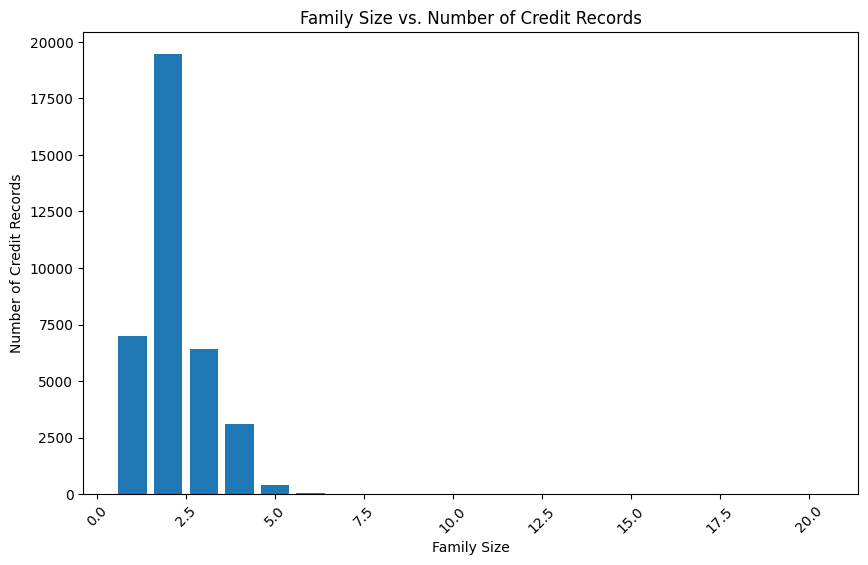

In [14]:
family_size_vs_credit_records = merge_record.groupby('CNT_FAM_MEMBERS')['MONTHS_IN_BOOKS'].count()
plt.figure(figsize=(10, 6))
plt.bar(family_size_vs_credit_records.index, family_size_vs_credit_records.values)
plt.xlabel('Family Size')
plt.ylabel('Number of Credit Records')
plt.title('Family Size vs. Number of Credit Records')
plt.xticks(rotation=45)
plt.show()

##### 5.2 Effect of Income on Preference Score

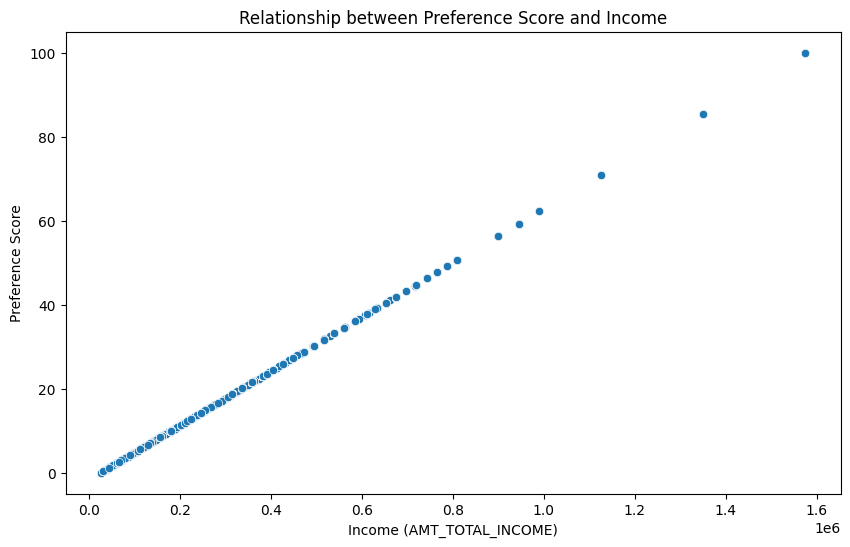

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AMT_INCOME_TOTAL', y='PREFERENCE_SCORE', data=merge_record)
plt.title('Relationship between Preference Score and Income')
plt.xlabel('Income (AMT_TOTAL_INCOME)')
plt.ylabel('Preference Score')
plt.show()

##### 5.3 Effect of Income on Good Debt and Bad Debt

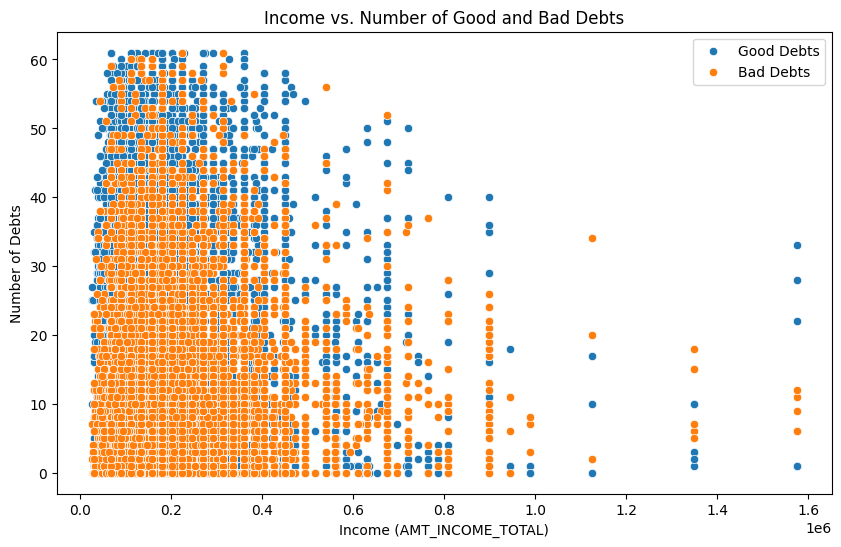

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AMT_INCOME_TOTAL', y='Good_Debt', data=merge_record, label='Good Debts')
sns.scatterplot(x='AMT_INCOME_TOTAL', y='Bad_Debt', data=merge_record, label='Bad Debts')
plt.title('Income vs. Number of Good and Bad Debts')
plt.xlabel('Income (AMT_INCOME_TOTAL)')
plt.ylabel('Number of Debts')
plt.legend()
plt.show()

### 6. Preparing Data and Model Training

In [17]:
status_dict = {'C' : 'Good_Debt',
               'X' : 'Good_Debt',
               '0' : 'Good_Debt',
               '1' : 'Good_Debt',
               '2' : 'Bad_Debt',
               '3' : 'Bad_Debt',
               '4' : 'Bad_Debt',
               '5' : 'Bad_Debt'}
credit_df.replace({'STATUS' : status_dict}, inplace=True)
credit_df = credit_df.value_counts(subset=['ID','STATUS']).unstack(fill_value=0)
credit_df.loc[(credit_df['Good_Debt'] > credit_df['Bad_Debt']), 'CREDIT_APPROVAL_STATUS'] = 1
credit_df.loc[(credit_df['Good_Debt'] <= credit_df['Bad_Debt']), 'CREDIT_APPROVAL_STATUS'] = 0
credit_df['MONTHS_IN_BOOKS'] = credit_df['Good_Debt'] + credit_df['Bad_Debt']
credit_df.drop(['Bad_Debt', 'Good_Debt'], axis=1, inplace=True)
application_df['DAYS_BIRTH'] = np.where(application_df['DAYS_BIRTH']<0,application_df['DAYS_BIRTH']*(-1),0)
application_df['DAYS_EMPLOYED'] = np.where(application_df['DAYS_EMPLOYED']<0,application_df['DAYS_EMPLOYED']*(-1),0)
application_df['DAYS_BIRTH'] = application_df['DAYS_BIRTH'].apply(lambda x: np.around(x/365))
application_df['DAYS_EMPLOYED'] = application_df['DAYS_EMPLOYED'].apply(lambda x: np.around(x/365))

comp_dataset = application_df.reset_index().merge(credit_df, on='ID').set_index('index')
comp_dataset.to_csv('comp_dataset.csv')

##### 5.1 Seperation of Numerical and Categorical values

In [18]:
isnull_sum = comp_dataset.isnull().sum()

num_vars = comp_dataset.select_dtypes(include=["int64", "float64"]).columns
num_vars_miss = [var for var in num_vars if isnull_sum[var]>0]

cat_vars = comp_dataset.select_dtypes(include=["object"]).columns
cat_vars_miss = [var for var in cat_vars if isnull_sum[var]>0]

print(num_vars,cat_vars)
print(num_vars_miss,cat_vars_miss)

Index(['ID', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'CREDIT_APPROVAL_STATUS', 'MONTHS_IN_BOOKS'],
      dtype='object') Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE'],
      dtype='object')
[] ['OCCUPATION_TYPE']


##### 5.2 Dealing with Skewness

In [19]:
unskewed_cols = [columns for columns in num_vars if ((comp_dataset[columns].skew())) > 1 | (comp_dataset[columns].skew()<-1)]
unskewed_cols

for columns in unskewed_cols:
    comp_dataset[columns] = np.where(comp_dataset[columns]<comp_dataset[columns].quantile(.15),comp_dataset[columns].quantile(.15),comp_dataset[columns])
    comp_dataset[columns] = np.where(comp_dataset[columns]>comp_dataset[columns].quantile(.85),comp_dataset[columns].quantile(.85),comp_dataset[columns])
comp_dataset.skew(numeric_only=True)

ID                        0.09
CNT_CHILDREN              0.83
AMT_INCOME_TOTAL          0.40
DAYS_BIRTH                0.00
DAYS_EMPLOYED             0.00
FLAG_MOBIL                0.00
FLAG_WORK_PHONE           1.31
FLAG_PHONE                0.90
FLAG_EMAIL                0.00
CNT_FAM_MEMBERS          -0.10
CREDIT_APPROVAL_STATUS   -0.08
MONTHS_IN_BOOKS           0.73
dtype: float64

##### 5.3 Seperation of Label and Feature

In [20]:
X = comp_dataset.drop(['CREDIT_APPROVAL_STATUS'],axis='columns')
y = comp_dataset['CREDIT_APPROVAL_STATUS']

##### 5.4 Creation of Pipeline (Imputing, encoding & scaling the data)

In [21]:
num_var_imputer = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean"))])
cat_vars_imputer = Pipeline(steps=[("imputer", SimpleImputer(strategy="constant", fill_value='missing'))])
scaling_pipeline = Pipeline(steps=[('std_scalar',StandardScaler())])

preprocessor = ColumnTransformer(transformers=[("mean_imputer", num_var_imputer, num_vars_miss),
                               ("missing_imputer", cat_vars_imputer,cat_vars_miss)])

label_encoder = LabelEncoder()
X['OCCUPATION_TYPE'] = preprocessor.fit_transform(X)
X= X.apply(label_encoder.fit_transform)

X = scaling_pipeline.fit_transform(X)

##### 5.5 Seperation for Traning and Testing

In [22]:
y = np.array(y)

In [23]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

##### 5.7 Model Evaluation

In [24]:
Model1 = ltb.LGBMClassifier(colsample_bytree=0.6247444707207354,
               learning_rate=0.2775782165459813, max_bin=1023,
               min_child_samples=14, n_estimators=27, num_leaves=52,
               reg_alpha=0.0013689282323546977, reg_lambda=0.21368755215090374,
               verbose=-1)
Model1.fit(X_train, y_train)
score1 = Model1.score(X_test, y_test)
print(score1)

0.716035838361675


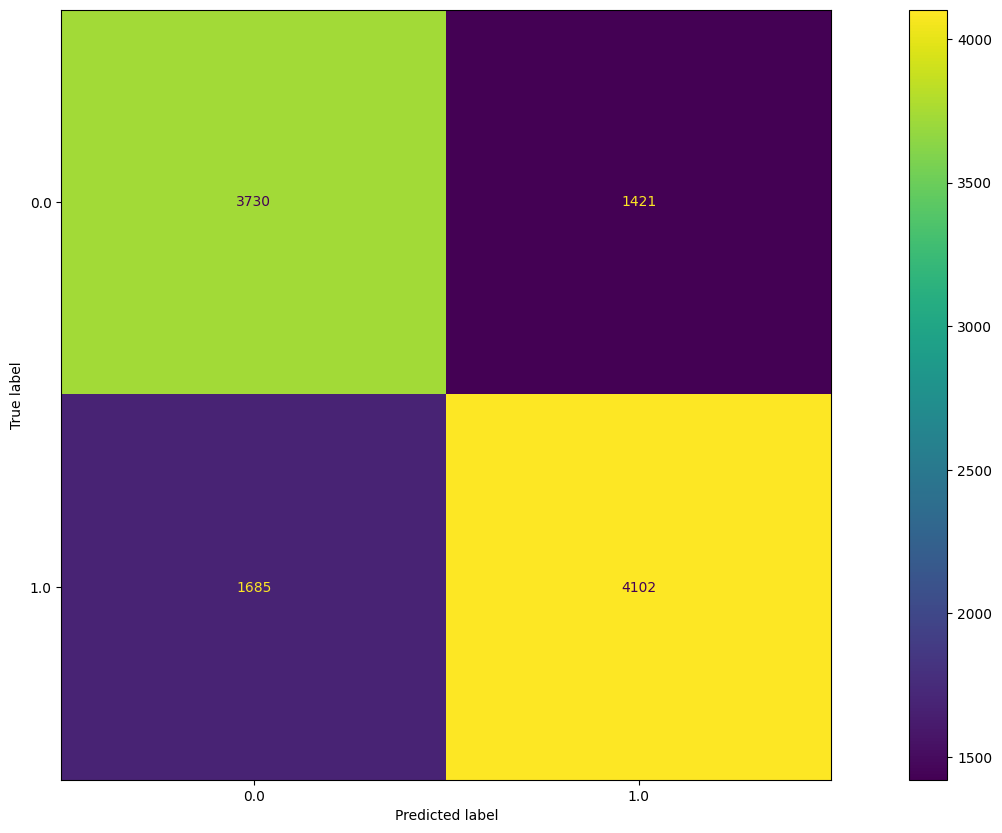

In [25]:

ConfusionMatrixDisplay.from_estimator(Model1, X_test, y_test)

In [26]:
# Model selected by us
Model2 = LogisticRegression()
Model2.fit(X_train, y_train)
score1 = Model2.score(X_test, y_test)
print(score1)

0.6971109892119217


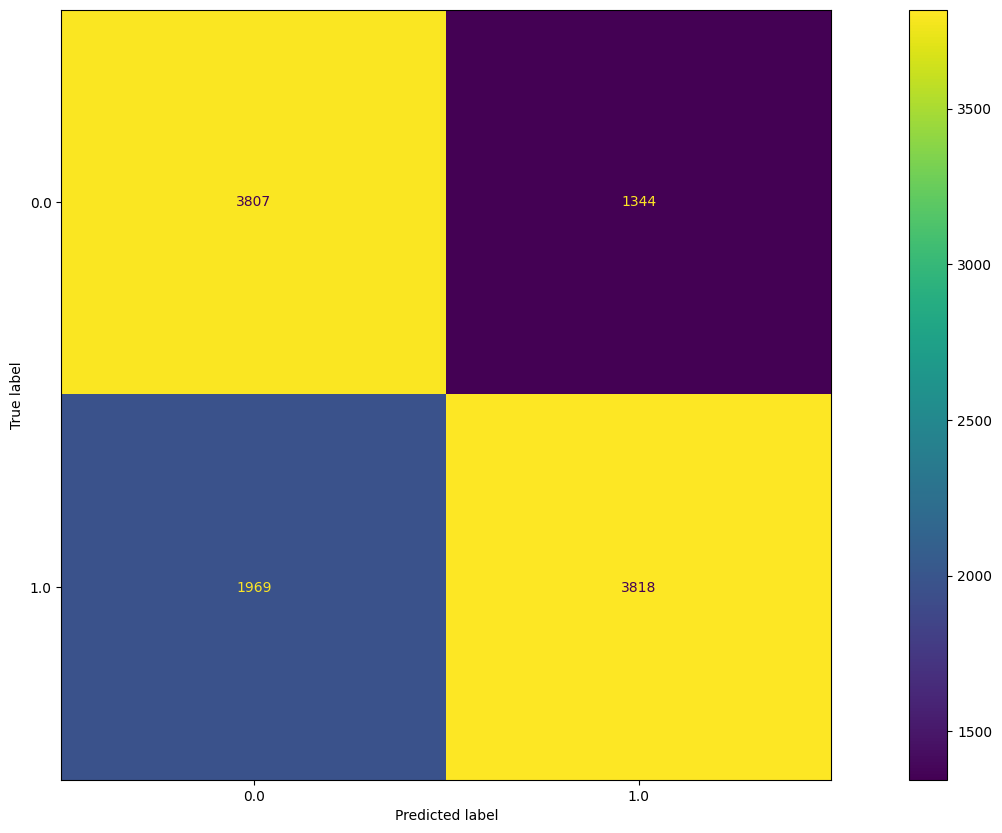

In [27]:
ConfusionMatrixDisplay.from_estimator(Model2, X_test, y_test)